## Vertical Spectra

Vertical spectra of tracers in the ocean are not usually considered, here we look at them. This follows some of the reasoning from Smith and Ferrari 09, where the horizontal-vertical spectra were computed.


In [1]:
from scipy.io import loadmat
import numpy as np
import xarray as xr

import glidertools as gt
import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm

from cmocean import cm as cmo

import xrft 

import gsw

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [3]:
ds_660_rho = xr.open_dataset('data/ctd_660_isopycnal_grid_4m_26_july_2021.nc')

# compute spice 
# Pick constant alpha and beta for convenience (can always update later)
alpha = 8e-5
beta  = 77.4e-5

# remove a mean per isopycnal
dCT = ds_660_rho.CT  - ds_660_rho.CT.mean('dives')
dSA = ds_660_rho.SA - ds_660_rho.SA.mean('dives')

ds_660_rho['Spice'] = (alpha*dCT + beta*dSA).rename('Spice')

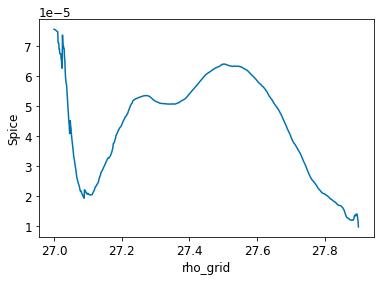

In [47]:
ds_660_rho['Spice'].std('dives').plot()

In [11]:
ds_660_rho

<xarray.Dataset>
Dimensions:       (dives: 1007, rho_grid: 901)
Coordinates:
  * rho_grid      (rho_grid) float64 27.0 27.0 27.0 27.0 ... 27.9 27.9 27.9 27.9
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    ctd_pressure  (rho_grid, dives) float64 ...
    CT            (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan
    SA            (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan
    latitude      (rho_grid, dives) float64 ...
    longitude     (rho_grid, dives) float64 ...
    days          (rho_grid, dives) float64 ...
    Spice         (rho_grid, dives) float64 nan nan nan nan ... nan nan nan nan

### Go back to Z grid

There are a few options on how to do this:
- Back to the original Z grid (this only requires us to reinterpolate spice, since we already have the other things on that grid. 
- A low pass version of Z (this will require to time filter out some high freq variability)
- A mean Z (the issue with this is that density range changed quite a bit b/w the experiment, and we might have to throw out a lot of data at the edges). 

#### First approach: 
Convert from z to ztilde. 

In [30]:
ds_660_grid = xr.open_dataset('data/ctd_660_vert_4m_binned_29_june_2021.nc')
# Calculate a time axis as YTD
days = ds_660_grid.time - np.datetime64('2019-01-01')
days_round_660 = (days / np.timedelta64(1, 'D')).round()
ds_660_grid['days'] = (days / np.timedelta64(1, 'D'))

In [33]:
# Practically define tilde as the average
rho_tilde = ds_660_grid.sigma0.mean('dives')
rho_prime = ds_660_grid.sigma0 - rho_tilde

In [34]:
g = 9.81
rho_0 = 1000
b_tilde = - (g*rho_tilde/rho_0).rename('b_tilde')
b_prime = - (g*rho_prime/rho_0).rename('b_prime')
N2 = (b_tilde.diff('ctd_pressure') / (-b_tilde.ctd_pressure).diff('ctd_pressure')).rename('N2')
# need '-' as the Z should be increasing towards the surface

Charney's vertical rescaling for QG is 
$$
d\tilde{z} = \frac{N}{f} dz
$$


For simplicity let's just apply it directly to CT, which is very similar looking to Spice (atleast at the largest scales).

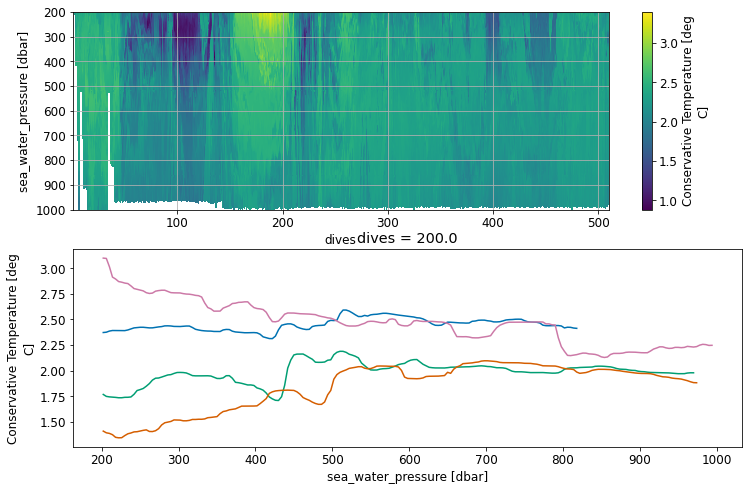

In [46]:
plt.figure(figsize=(12,8))

plt.subplot(211)
ds_660_grid.CT.sel(ctd_pressure=slice(200,1000)).plot()
plt.grid()
plt.gca().invert_yaxis()

plt.subplot(212)
ds_660_grid.CT.sel(ctd_pressure=slice(200,1000)).sel(dives=40).plot()
ds_660_grid.CT.sel(ctd_pressure=slice(200,1000)).sel(dives=80).plot()
ds_660_grid.CT.sel(ctd_pressure=slice(200,1000)).sel(dives=120).plot()
ds_660_grid.CT.sel(ctd_pressure=slice(200,1000)).sel(dives=200).plot()

In [130]:
dz = ds_660_grid.ctd_pressure.diff('ctd_pressure').mean() # 4m
N = N2.rolling(ctd_pressure=10, center=True).mean()**0.5 # do a little smoothing
f = np.abs(2*2*np.pi/24/3600*np.sin(-51*np.pi/180))
dz_tilde = dz*N/f

z_tilde = np.cumsum(dz_tilde)

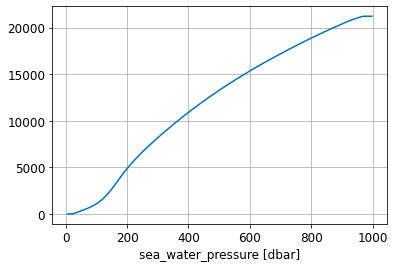

In [131]:
z_tilde.sel(ctd_pressure = slice(0, 1000)).plot()
plt.grid()

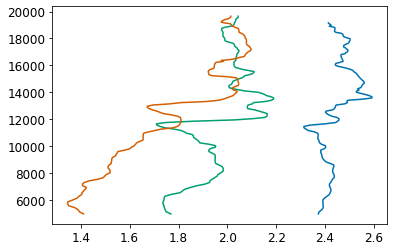

In [128]:
plt.plot(ds_660_grid.CT.sel(ctd_pressure=slice(200,850)).sel(dives=40), 
         z_tilde.sel(ctd_pressure=slice(200,850)))
plt.plot(ds_660_grid.CT.sel(ctd_pressure=slice(200,850)).sel(dives=80), 
         z_tilde.sel(ctd_pressure=slice(200,850)))
plt.plot(ds_660_grid.CT.sel(ctd_pressure=slice(200,850)).sel(dives=120), 
         z_tilde.sel(ctd_pressure=slice(200,850)))


In [ ]:
from scipy import interpolate

In [132]:
# Interpolate from z to z_tilde 
dive_num = 400
#z = ds_660_grid.ctd_pressure
z_tilde_sel = z_tilde.sel(ctd_pressure=slice(200, 900))
y = ds_660_grid.CT.sel(dives=dive_num).sel(ctd_pressure=slice(200, 900))

z_tilde_grid = np.arange(z_tilde_sel.min(), z_tilde_sel.max(), 
                           dz_tilde.sel(ctd_pressure=slice(200,900)).min() )

f = interpolate.PchipInterpolator(z_tilde_sel, y)
y_tilde = f(z_tilde_grid)

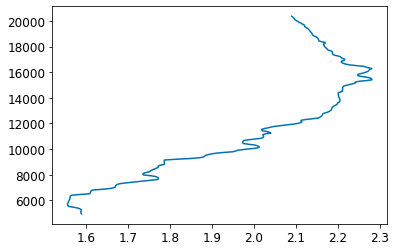

In [127]:
plt.plot(y_tilde, z_tilde_grid)

In [140]:
def func_var_ztilde_int(ds, var):
    
    dep_slice = slice(200, 900)
    dive_num = ds['dives'].values
    
    y_sel = ds_660_grid.CT.sel(dives=dive_num).sel(ctd_pressure = dep_slice)
    y_nonan = y_sel.where(~np.isnan(y_sel), drop=True)
    
    z_tilde_sel = z_tilde.sel(ctd_pressure = dep_slice)
    z_tilde_nonan = z_tilde_sel.where(~np.isnan(y_sel), drop=True)
    
    z_tilde_grid = np.arange(z_tilde_sel.min(), 
                             z_tilde_sel.max(), 
                             dz_tilde.sel(ctd_pressure=dep_slice).min() )
    
    
    
    if len(y_nonan)>2:
        f = interpolate.PchipInterpolator(z_tilde_nonan, y_nonan, extrapolate=False)
    
        y_tilde_sel = f(z_tilde_grid)
    else:
        y_tilde_sel = np.nan*z_tilde_grid
    
    return xr.DataArray(y_tilde_sel.reshape(-1, 1), 
                          dims = ['z_tilde', 'dives'],
                          coords = {'z_tilde': z_tilde_grid, 'dives': [dive_num]} )

In [142]:
dive_ind = 0

CT_tilde_xr = func_var_ztilde_int(ds_660_grid.isel(dives=dive_ind), 'CT')

for dive_ind in range(1, len(ds_660_grid.dives)):
    if np.mod(dive_ind, 100)==0:
        print(dive_ind)
    CT_tilde_xr = xr.concat([CT_tilde_xr , func_var_ztilde_int(ds_660_grid.isel(dives=dive_ind), 'CT')], dim='dives')
    
    

100
200
300
400
500
600
700
800
900
1000


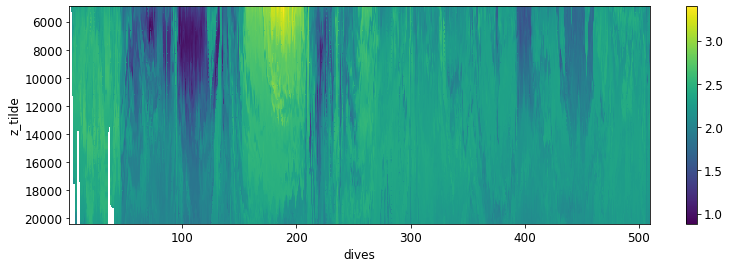

In [145]:
plt.figure(figsize=(13, 4))
CT_tilde_xr.plot()
plt.gca().invert_yaxis()

In [148]:
CT_tilde_xr.dropna(dim='dives')

<xarray.DataArray (z_tilde: 265, dives: 978)>
array([[2.36163993, 2.3399104 , 2.38739764, ..., 2.15269882, 2.09571338,
        2.23792222],
       [2.36475254, 2.3412437 , 2.38982239, ..., 2.15751282, 2.10130073,
        2.24451226],
       [2.36714678, 2.34325102, 2.39303546, ..., 2.16056869, 2.10727105,
        2.25109303],
       ...,
       [2.05636715, 2.24027944, 2.16877991, ..., 2.18076284, 2.16872965,
        2.15788184],
       [2.05628173, 2.2075454 , 2.13521472, ..., 2.18053755, 2.16892815,
        2.16057848],
       [2.05516294, 2.1476003 , 2.12719391, ..., 2.18323662, 2.16900981,
        2.15407624]])
Coordinates:
  * z_tilde  (z_tilde) float64 4.943e+03 5.002e+03 ... 2.03e+04 2.036e+04
  * dives    (dives) float64 6.0 11.0 11.5 12.0 12.5 ... 508.0 508.5 509.0 509.5

In [146]:
import xrft

In [154]:
CT_spec_ztilde = xrft.power_spectrum(CT_tilde_xr.dropna(dim='dives') - CT_tilde_xr.mean('dives'),
                                     dim='z_tilde', window=True)

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


Text(0.5, 0, '$\\lambda$ [1/m]')

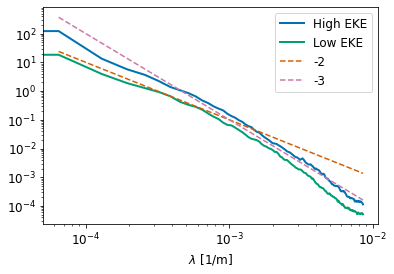

In [167]:
CT_spec_ztilde.sel(dives=slice(0,250)).mean('dives').plot(label='High EKE', linewidth=2)
CT_spec_ztilde.sel(dives=slice(250,500)).mean('dives').plot(label='Low EKE', linewidth=2)

kz = CT_spec_ztilde.freq_z_tilde

plt.plot(kz, 1e-7*kz**(-2), '--', label='-2')
plt.plot(kz, 1e-10*kz**(-3), '--', label='-3')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')

Text(0.5, 0, '$\\lambda$ [1/m]')

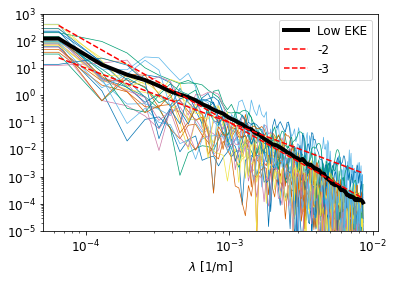

In [173]:
for i in range(1,250,10):
    CT_spec_ztilde.sel(dives=i, method='nearest').plot(linewidth=.7)
CT_spec_ztilde.sel(dives=slice(0,250)).mean('dives').plot(label='Low EKE', linewidth=4, color='k')

kz = CT_spec_ztilde.freq_z_tilde

plt.plot(kz, 1e-7*kz**(-2), '--', label='-2', color='r')
plt.plot(kz, 1e-10*kz**(-3), '--', label='-3', color='r')

plt.legend()
plt.ylim([1e-5, 1e3])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')

The vertical spectra shown above is a new metric, which has not been presented before. 
Here is our naive interpretation, but more work needs to be done. 

- The slope at large scales, larger than equivalent 2km, is similar to what is observed at horizontal scales with a slope of -2. 
- At smaller scales the slope is even steeper, with -3 slope. This is suggestive that there are small submesoscales active in the interior. 
- Changing from z to $\tilde{z}$ did not change things much here because the change in N is gentle. 

#### Second approach

Convert from z to ztilde, but first remove the waves using some filter. 

In [18]:
# Calculate N
g = 9.81
rho_0 = 1000 
mean_z = ds_660_rho.ctd_pressure.mean('dives')

N2_mean = (g/rho_0*ds_660_rho.rho_grid.diff('rho_grid')/ 
            mean_z.diff('rho_grid'))

N2 = (g/rho_0*ds_660_rho.rho_grid.diff('rho_grid')/ 
            ds_660_rho.ctd_pressure.diff('rho_grid'))

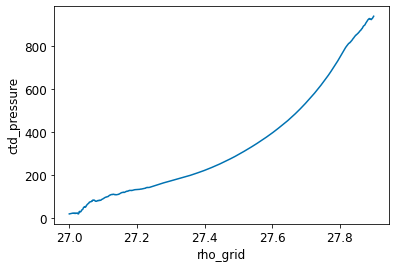

In [28]:
mean_z.plot()

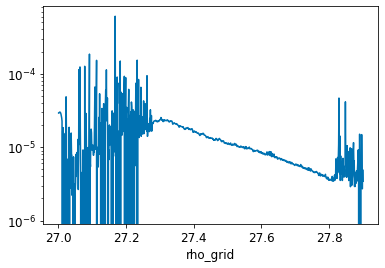

In [17]:
N2_mean.plot()
plt.yscale('log')

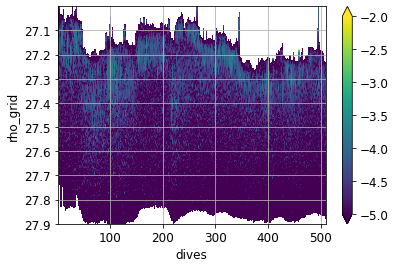

In [27]:
np.log10(N2).plot(vmin=-5, vmax=-2)
plt.grid()
plt.gca().invert_yaxis()

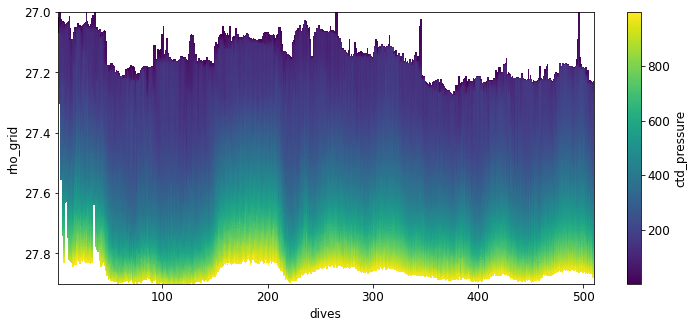

In [6]:
plt.figure(figsize=(12,5))
ds_660_rho.ctd_pressure.plot()
plt.gca().invert_yaxis()

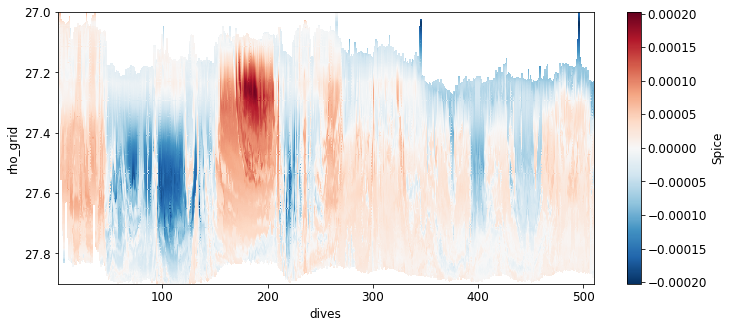

In [4]:
plt.figure(figsize=(12,5))
ds_660_rho.Spice.plot()
plt.gca().invert_yaxis()

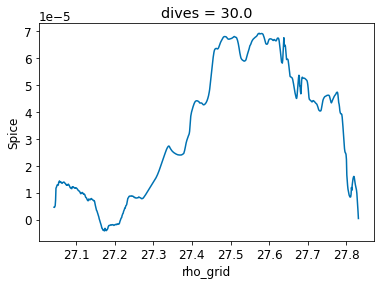

In [7]:
ds_660_rho.Spice.sel(dives=30).plot()

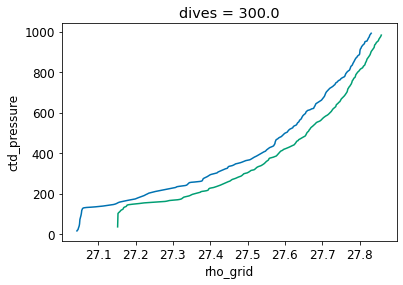

In [10]:
ds_660_rho.ctd_pressure.sel(dives=30).plot()
ds_660_rho.ctd_pressure.sel(dives=300).plot()

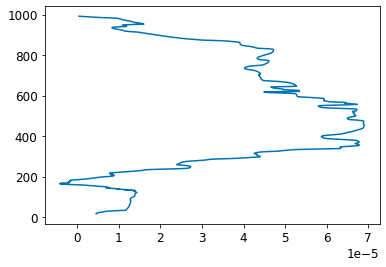

In [8]:
plt.plot(ds_660_rho.Spice.sel(dives=30), 
         ds_660_rho.ctd_pressure.sel(dives=30))

In [3]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data'
data_659 = data_dir+'/data/interim/gliders/sg659/CTD_659.nc'
data_660 = data_dir+'/data/interim/gliders/sg660/CTD_660.nc'

ds_659 = xr.load_dataset(data_659)
ds_660 = xr.load_dataset(data_660)

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/dhruvbalwada/OneDrive/sogos_data/data/interim/gliders/sg659/CTD_659.nc'

In [4]:
# Calculate a time axis as YTD
days = ds_659.time - np.datetime64('2019-01-01')
days_round_659 = (days / np.timedelta64(1, 'D')).round()
ds_659['days'] = (days / np.timedelta64(1, 'D'))

days = ds_660.time - np.datetime64('2019-01-01')
days_round_660 = (days / np.timedelta64(1, 'D')).round()
ds_660['days'] = (days / np.timedelta64(1, 'D'))

In [5]:
# Calculate an along glider path distance axis
dist_659 = gt.utils.distance(ds_659.longitude, 
                       ds_659.latitude)

ds_659['distance'] = xr.DataArray(np.cumsum(dist_659), 
                           dims= ['ctd_data_point'])

dist_660 = gt.utils.distance(ds_660.longitude, 
                       ds_660.latitude)
ds_660['distance'] = xr.DataArray(np.cumsum(dist_660), 
                           dims= ['ctd_data_point'])

In [6]:
# Calculate the potential density
ds_659['potdens'] = gt.physics.potential_density(ds_659.salinity, 
                                                 ds_659.temperature, 
                                                 ds_659.pressure, 
                                                 ds_659.latitude, 
                                                 ds_659.longitude)

ds_660['potdens'] = gt.physics.potential_density(ds_660.salinity, 
                                                 ds_660.temperature, 
                                                 ds_660.pressure,
                                                 ds_660.latitude, 
                                                 ds_660.longitude)


In [9]:
# Calculate the spice based on the TEOS10 function
# 
# It remains unclear to me if this is the right thing to do, 
# or should we be using a locally referenced variable. 
# Discuss and iterate on this. 

ds_659['spice'] = gt.physics.spice0(ds_659.salinity, 
                         ds_659.temperature, 
                         ds_659.pressure, 
                         ds_659.latitude, 
                         ds_659.longitude)

ds_660['spice'] = gt.physics.spice0(ds_660.salinity, 
                         ds_660.temperature, 
                         ds_660.pressure, 
                         ds_660.latitude, 
                         ds_660.longitude)

In [10]:
# Interpolate and grid glider data on pressure-time axis

# Note this is different from what glidertools does, which does a simple binning. 

from scipy.interpolate import griddata
# interpolate on pressure-time 
def interp_pres_time(ds_glid, var): 
    pres_ug = ds_glid.pressure
    time_ug = ds_glid.days
    
    # convert to points values
    points = np.stack([time_ug.values, pres_ug.values],
                       axis=1)
    values = ds_glid[var].values
    
    # remove nans
    non_nan = np.logical_and(np.logical_and(~np.isnan(points[:,0]), 
                                      ~np.isnan(points[:,1])),
                                      ~np.isnan(values))
    
    points =points[non_nan,:]
    values =values[non_nan]
    
    # define grid
    # choose grid size that smaller than most of the sampling points 
    # so we avoid aliasing in this step.
    pres_grid = np.linspace(0,1000,2001) 
    time_grid = np.arange(119, 207, 0.025)
    grid_p, grid_t = np.meshgrid(pres_grid, time_grid)
    
    temp_grided = griddata(points, values, 
                         (grid_t, grid_p), 
                         method='linear', rescale=True)
    
    return xr.DataArray(temp_grided.T, 
                               dims=["pressure", "time"],
                          coords={"pressure":pres_grid,
                                    "time":time_grid}).rename(var)

# apply to all useful glider variables 
# can later add in variables measured by other instruments too 
def convert_glider(ds_glid, vars_convert= ['temperature','salinity','potdens','spice']):
    
    #vars_convert = ['temperature','salinity','potdens']
    
    ds_grid = xr.Dataset()
    
    for v in vars_convert:
            ds_grid[v] = interp_pres_time(ds_glid, v)
    
    return ds_grid

In [11]:
# convert from point data to gridded data, can take some time
ds_659_grid = convert_glider(ds_659)
ds_660_grid = convert_glider(ds_660)